In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Train

In [104]:
train = pd.read_csv("./train_data_withlabels.csv")
train = train.iloc[:, 1:]

# change type from string to datetime object
train.localminute = pd.to_datetime(train.localminute)

# create new columns
train['month'] = train.localminute.dt.month
train['date'] = train.localminute.dt.day
train['weekday'] = train.localminute.dt.weekday
train['hour'] = train.localminute.dt.hour
train['minute'] = train.localminute.dt.minute

# remove localminute column
train = train.iloc[:, 1:]

# move target column just for ease
target = train.pop('target')
train['target'] = target

# get column names
col_names = train.columns.to_list()

target = train.target
feature_a = train.iloc[:,0:7].columns.to_list()
feature_b = train.iloc[:,7:-1].columns.to_list()
normal_standard = ColumnTransformer([('standardscaler', StandardScaler(), feature_a)], 
                                    remainder='passthrough')
normal_minmax = ColumnTransformer([('minmaxscaler', MinMaxScaler(), feature_b)], 
                                  remainder='passthrough')

# use sklearn to normalize data
#pipe_me = Pipeline([("standard", normal_standard), ("minmax", normal_minmax)]).fit(train.drop('target', axis = 1))
train_normal = pd.DataFrame(normal_standard.fit_transform(train))
# rename columns
train_normal.columns = col_names
# do the rest
train_normal = pd.DataFrame(normal_minmax.fit_transform(train_normal))

# rename columns
train_normal.columns = feature_b + feature_a + ["target"]

In [121]:
train_f = train_normal.drop('month', axis = 1)

# convert dates to categorical
train_f['date'] = train_f['date'].astype('category')
train_f['weekday'] = train_f['weekday'].astype('category')
train_f['hour'] = train_f['hour'].astype('category')
train_f['minute'] = train_f['minute'].astype('category')

targ = train_f.target
train_f = train_f.drop('target', axis = 1)
train_f['target'] = targ

# dummies
#train_f = pd.get_dummies(train_f) 

# split to train and validation
validation_x, train_x = train_test_split(train_f, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.drop('target', axis = 1)

validation_y = validation_x.target
validation_x = validation_x.drop('target', axis = 1)

#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.420
Model:                            OLS   Adj. R-squared (uncentered):              0.420
Method:                 Least Squares   F-statistic:                          2.491e+04
Date:                Tue, 07 Jun 2022   Prob (F-statistic):                        0.00
Time:                        15:30:31   Log-Likelihood:                      1.1694e+05
No. Observations:              377828   AIC:                                 -2.339e+05
Df Residuals:                  377817   BIC:                                 -2.337e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [122]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)

val_y = lr_model.predict(validation_x)
pred_y = lr_model.predict(train_x)

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    357278
         1.0       0.82      0.71      0.76     20550

    accuracy                           0.98    377828
   macro avg       0.90      0.85      0.87    377828
weighted avg       0.97      0.98      0.98    377828

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     39688
         1.0       0.84      0.73      0.78      2292

    accuracy                           0.98     41980
   macro avg       0.91      0.86      0.88     41980
weighted avg       0.98      0.98      0.98     41980



In [45]:
d_max = 50

#df = pd.DataFrame({"N" : list(range(1, d_max+1)), "acc_t" : 0*d_max, "acc_v" : 0*d_max})

for d in range(30 , d_max+1):
    
    df.loc[d-1] = [d, 0, 0]
    
    # train model
    rf_model = RandomForestClassifier(max_depth = d, random_state=0).fit(train_x, train_y)
    pred_y = rf_model.predict(train_x) # change var here
    val_y = rf_model.predict(validation_x) # change var here
    
    # get accuracy for train prediction
    tn, fp, fn, tp = confusion_matrix(train_y, pred_y).ravel()
    acc_t = (tn + tp) / (tn + fp + tp +fn)
    df.iloc[d-1, 1] = acc_t
    
    # get accuracy for validation prediction
    tn, fp, fn, tp = confusion_matrix(validation_y, val_y).ravel()
    acc_v = (tn + tp) / (tn + fp + tp + fn)
    df.iloc[d-1, 2] = acc_v
    
    print(d, " done!")
    
print("Done!")

30  done!
31  done!
32  done!
33  done!
34  done!
35  done!
36  done!
37  done!
38  done!
39  done!
40  done!
41  done!
42  done!
43  done!
44  done!
45  done!
46  done!
47  done!
48  done!
49  done!
50  done!
Done!


In [106]:
x_max = [100,200,300,400,500,600,700,800,900,1000,2000]

df = pd.DataFrame({"N" : x_max, "acc_t" : 0*len(x_max), "acc_v" : 0*len(x_max)})

for d in range(1 , len(x_max)+1):
    
    x = x_max[d-1]
    
    df.loc[d-1] = [d, 0, 0]
    
    # train model
    xg_model = xgb.XGBClassifier(learning_rate = 0.05, max_depth = 35, reg_lambda = 10, n_estimators = x).fit(train_x,train_y)

    pred_y = xg_model.predict(train_x) # change var here
    val_y = xg_model.predict(validation_x) # change var here
    
    # get accuracy for train prediction
    tn, fp, fn, tp = confusion_matrix(train_y, pred_y).ravel()
    acc_t = (tn + tp) / (tn + fp + tp +fn)
    df.iloc[d-1, 1] = acc_t
    
    # get accuracy for validation prediction
    tn, fp, fn, tp = confusion_matrix(validation_y, val_y).ravel()
    acc_v = (tn + tp) / (tn + fp + tp + fn)
    df.iloc[d-1, 2] = acc_v
    
    print(x, " done!")
    
print("Done!")

100  done!
200  done!
300  done!
400  done!
500  done!
600  done!
700  done!
800  done!
900  done!
1000  done!
2000  done!
Done!


In [116]:
df.iloc[:,0] = x_max

In [117]:
df

,N,acc_t,acc_v
0,100,0.999037,0.996808
1,200,0.999794,0.997808
2,300,0.999934,0.997999
3,400,0.999976,0.998166
4,500,0.999989,0.998166
5,600,0.999995,0.998213
6,700,0.999997,0.998285
7,800,0.999997,0.998333
8,900,1.000000,0.998333
9,1000,1.000000,0.998309


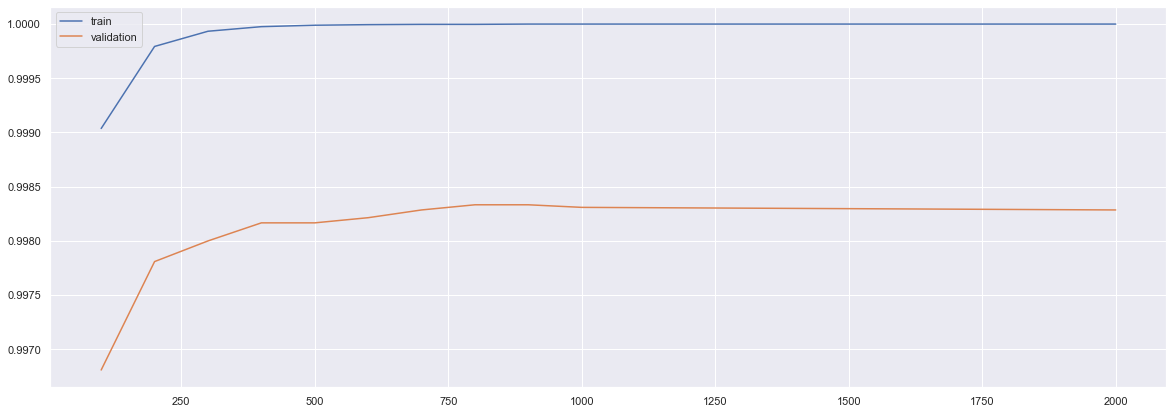

In [118]:
fig = plt.figure(figsize =(20, 7))
ax = fig.add_subplot(111)

ax.plot(df.N, df.acc_t, label = "train")
ax.plot(df.N, df.acc_v, label = "validation")
ax.legend()

In [38]:
xg_data = xgb.DMatrix(train_x,train_y)

xg_model = xgb.XGBClassifier(learning_rate = 0.5, max_depth = 30, alpha = 10).fit(train_x,train_y)

val_y = xg_model.predict(validation_x)
pred_y = xg_model.predict(train_x)

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    357344
         1.0       1.00      0.99      1.00     20484

    accuracy                           1.00    377828
   macro avg       1.00      1.00      1.00    377828
weighted avg       1.00      1.00      1.00    377828

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     39622
         1.0       0.98      0.97      0.98      2358

    accuracy                           1.00     41980
   macro avg       0.99      0.99      0.99     41980
weighted avg       1.00      1.00      1.00     41980



In [37]:
? XGBClassifier

# Correlation

<AxesSubplot:>

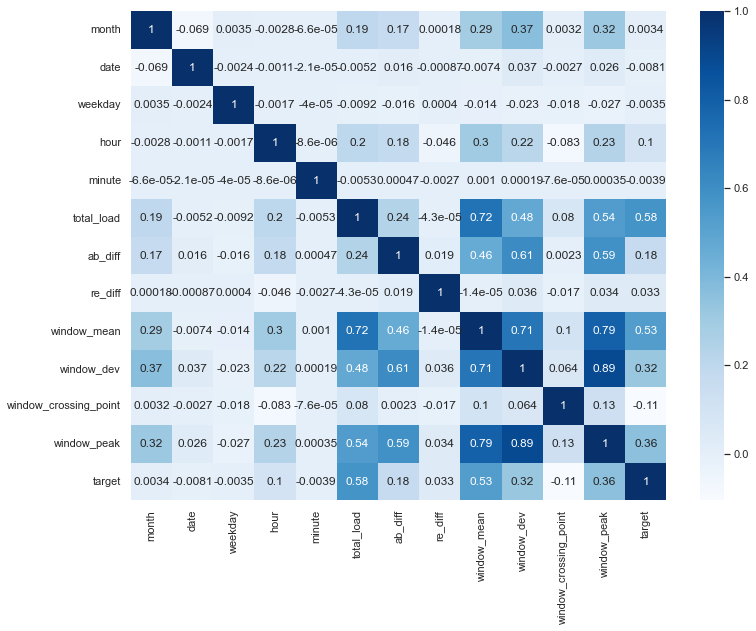

In [5]:
c = train_normal.corr()

sns.set(rc={'figure.figsize':(12,9)})

sns.heatmap(c, cmap="Blues", annot=True)

In [6]:
top = c.iloc[:, -1:].reindex(c.target.abs().sort_values(ascending = False).index).iloc[1:, :]
top_features = top.index.to_list()
top

,target
total_load,0.576940
window_mean,0.529645
window_peak,0.357295
window_dev,0.324742
ab_diff,0.175344
window_crossing_point,-0.105124
hour,0.100808
re_diff,0.033362
date,-0.008135
minute,-0.003857


# Test

In [141]:
train_y = train_normal.target
train_x = train_normal.drop('target', axis = 1)

train_x = train_x.drop('month', axis = 1)

# convert dates to categorical
train_x['date'] = train_x['date'].astype('category')
train_x['weekday'] = train_x['weekday'].astype('category')
train_x['hour'] = train_x['hour'].astype('category')
train_x['minute'] = train_x['minute'].astype('category')

train_x = pd.get_dummies(train_x)

In [142]:
feature_a = train.iloc[:,0:7].columns.to_list()
feature_b = train.iloc[:,8:-1].columns.to_list()
normal_standard = ColumnTransformer([('standardscaler', StandardScaler(), feature_a)], 
                                    remainder='passthrough')
normal_minmax = ColumnTransformer([('minmaxscaler', MinMaxScaler(), feature_b)], 
                                  remainder='passthrough')

test = pd.read_csv("./test_data_nolabels.csv")

# transform test data

# get dataid
test_id = test.dataid

# change type from string to datetime object
test.localminute = pd.to_datetime(test.localminute)

# create new columns
test['date'] = test.localminute.dt.day
test['weekday'] = test.localminute.dt.weekday
test['hour'] = test.localminute.dt.hour
test['minute'] = test.localminute.dt.minute

# remove localminute and dataid column
test = test.drop(['dataid', 'localminute'], axis = 1)

col_names = test.columns

# normalise test data
test = pd.DataFrame(normal_standard.fit_transform(test))
# rename columns
test.columns = col_names
# do the rest
test = pd.DataFrame(normal_minmax.fit_transform(test))
# rename columns
test.columns = feature_b + feature_a

# select test columns
#test = test[features]

# convert dates to categorical
test['date'] = test['date'].astype('category')
test['weekday'] = test['weekday'].astype('category')
test['hour'] = test['hour'].astype('category')
test['minute'] = test['minute'].astype('category')

test = pd.get_dummies(test)

In [127]:
k_model = KNeighborsClassifier(n_neighbors = 1, algorithm = "kd_tree").fit(train_x, train_y)

k_test = k_model.predict(test).astype('int')

k_final = pd.DataFrame({"dataid" : test_id, "target" : k_test})
k_final.to_csv("k_result.csv", index = False)
print(k_final.target.value_counts())

0    99251
1     5701
Name: target, dtype: int64


In [128]:
rf_model = RandomForestClassifier(max_depth = 35, random_state=0).fit(train_x, train_y)

rf_test = rf_model.predict(test).astype('int')

rf_final = pd.DataFrame({"dataid" : test_id, "target" : rf_test})
rf_final.to_csv("rf_result.csv", index = False)
print(rf_final.target.value_counts())

0    99726
1     5226
Name: target, dtype: int64


AttributeError: 'XGBClassifier' object has no attribute 'tree_'

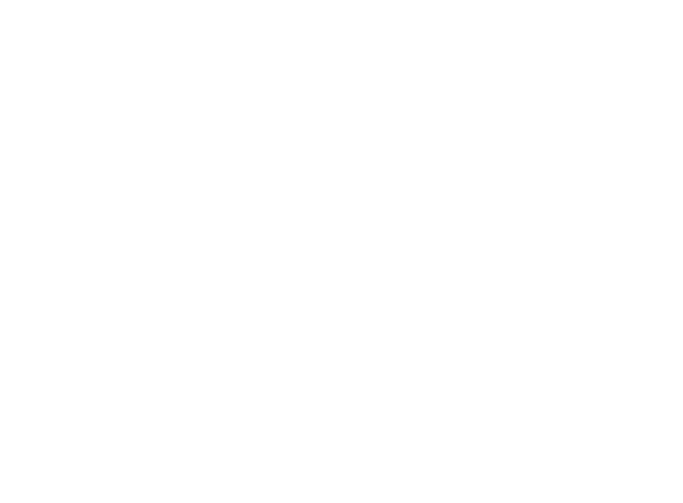

In [138]:
from sklearn.tree import plot_tree

plot_tree(rf_model)

In [143]:
xg_model = xgb.XGBClassifier(learning_rate = 0.05, max_depth = 35, reg_lambda = 10, n_estimators = 800).fit(train_x,train_y)

xg_test = xg_model.predict(test).astype('int')

xg_final = pd.DataFrame({"dataid" : test_id, "target" : xg_test})
xg_final.to_csv("xg_result.csv", index = False)
print(xg_final.target.value_counts())

0    99423
1     5529
Name: target, dtype: int64


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

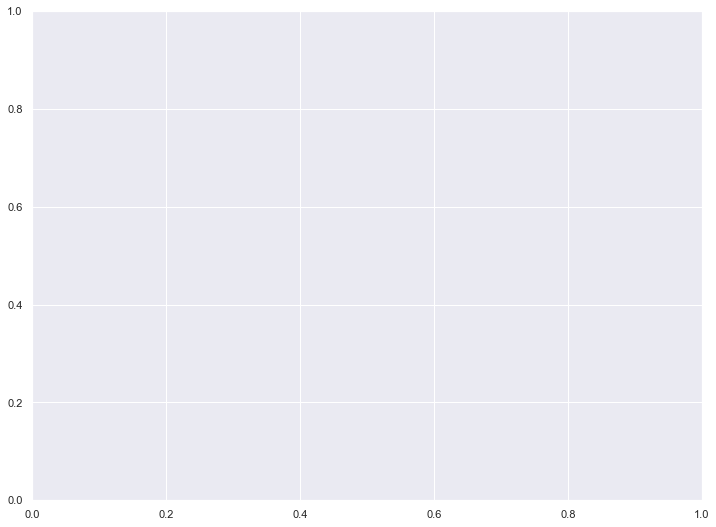

In [139]:
from xgboost import plot_tree as pt
import matplotlib.pyplot as plt

pt(xg_model)

## No Dummies

In [119]:
# train no dummies

train_y = train_normal.target
train_x = train_normal.drop('target', axis = 1)

train_x = train_x.drop('month', axis = 1)

# test no dummies

feature_a = train.iloc[:,0:7].columns.to_list()
feature_b = train.iloc[:,8:-1].columns.to_list()
normal_standard = ColumnTransformer([('standardscaler', StandardScaler(), feature_a)], 
                                    remainder='passthrough')
normal_minmax = ColumnTransformer([('minmaxscaler', MinMaxScaler(), feature_b)], 
                                  remainder='passthrough')

test = pd.read_csv("./test_data_nolabels.csv")

# transform test data

# get dataid
test_id = test.dataid

# change type from string to datetime object
test.localminute = pd.to_datetime(test.localminute)

# create new columns
test['date'] = test.localminute.dt.day
test['weekday'] = test.localminute.dt.weekday
test['hour'] = test.localminute.dt.hour
test['minute'] = test.localminute.dt.minute

# remove localminute and dataid column
test = test.drop(['dataid', 'localminute'], axis = 1)

col_names = test.columns

# normalise test data
test = pd.DataFrame(normal_standard.fit_transform(test))
# rename columns
test.columns = col_names
# do the rest
test = pd.DataFrame(normal_minmax.fit_transform(test))
# rename columns
test.columns = feature_b + feature_a

# select test columns
#test = test[features]

# convert dates to categorical
test['date'] = test['date'].astype('category')
test['weekday'] = test['weekday'].astype('category')
test['hour'] = test['hour'].astype('category')
test['minute'] = test['minute'].astype('category')

In [120]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)

lr_test = lr_model.predict(test).astype('int')

lr_final = pd.DataFrame({"dataid" : test_id, "target" : lr_test})
lr_final.to_csv("lr_result.csv", index = False)
print(lr_final.target.value_counts())
print(lr_model.coef_, lr_model.intercept_)

0    98416
1     6536
Name: target, dtype: int64
[[-0.43011004  0.14269358 -1.48071357 -0.08601288  1.83567011 -0.15163288
   0.09867033  1.68454476  0.76459465 -1.35974101 -0.97647455]] [-5.83595267]


In [123]:
train_x.columns

Index(['date', 'weekday', 'hour', 'minute', 'total_load', 'ab_diff', 're_diff',
       'window_mean', 'window_dev', 'window_crossing_point', 'window_peak'],
      dtype='object')